# Traffic Forecasting: EDA, Feature Engineering, and Modeling

This notebook follows the structure below:

1. Exploratory Data Analysis (EDA) & Data Preparation
   - Data Cleaning & Pre-processing (load, clean, aggregate, preprocess)
   - Feature Engineering & Selection (time features, lags, weekends/holidays, importance)
2. Data Modeling & Model Evaluation
   - Model Development and Training (ARIMA, tree-based, optional LSTM)
   - Model Evaluation & Cross-Validation (MAE, RMSE, R-squared, residuals, time-based CV)
   - Model Refinement (diagnose, improve features, tune hyperparameters)

Use the section headers as guideposts; each block is self-contained where possible to support re-execution.

In [ ]:
import pandas as pd
import numpy as np

# Use configured paths instead of Colab paths
Uber_Traffic = pd.read_csv("/content/drive/MyDrive/Datasets/Dataset_Uber_Traffic.csv")
Weather_data = pd.read_csv("/content/drive/MyDrive/Datasets/weatherHistory.csv")
Holiday_data = pd.read_csv("/content/drive/MyDrive/Datasets/Holidays.csv")

display(Uber_Traffic.head())
display(Weather_data.head())
display(Holiday_data.head())

,DateTime,Junction,Vehicles,ID
0,01/11/15 0:00,1,15,20151101001
1,01/11/15 1:00,1,13,20151101011
2,01/11/15 2:00,1,10,20151101021
3,01/11/15 3:00,1,7,20151101031
4,01/11/15 4:00,1,9,20151101041


,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


,Unnamed: 0,Name,Date,Public,Country,Weekday
0,0,Republic Day,2022-01-26,True,India,Wednesday
1,1,Valentine's Day,2022-02-14,False,India,Monday
2,2,March Equinox,2022-03-20,False,India,Sunday
3,3,Bank Holiday,2022-04-01,False,India,Friday
4,4,Doctor Ambedkar's Birthday,2022-04-14,False,India,Thursday


## 1. Exploratory Data Analysis (EDA) & Data Preparation

### 1.1 Data Cleaning & Pre-processing

In [ ]:
Weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [ ]:
print("Number of null values in 'Precip Type' before handling:")
print(Weather_data['Precip Type'].isnull().sum())

mode_precip_type = Weather_data['Precip Type'].mode()[0]

Weather_data['Precip Type'].fillna(mode_precip_type, inplace=True)

print("\nNumber of null values in 'Precip Type' after handling:")
print(Weather_data['Precip Type'].isnull().sum())

Number of null values in 'Precip Type' before handling:
517

Number of null values in 'Precip Type' after handling:
0


/tmp/ipython-input-3994714646.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Weather_data['Precip Type'].fillna(mode_precip_type, inplace=True)


In [ ]:
# Normalize and align timestamps to hourly
Uber_Traffic['DateTime'] = pd.to_datetime(Uber_Traffic['DateTime'], infer_datetime_format=True, dayfirst=True)
Uber_Traffic['DateTime'] = Uber_Traffic['DateTime'].dt.floor('H')

Weather_data['Formatted Date'] = pd.to_datetime(Weather_data['Formatted Date'], utc=True).dt.tz_convert(None)
Weather_data['Formatted Date'] = Weather_data['Formatted Date'].dt.floor('H')

# Optional: aggregate weather hourly if multiple rows per hour
weather_hourly = (Weather_data
                  .sort_values('Formatted Date')
                  .groupby('Formatted Date', as_index=False)
                  .agg({
                      'Summary': 'last',
                      'Precip Type': 'last',
                      'Temperature (C)': 'mean',
                      'Apparent Temperature (C)': 'mean',
                      'Humidity': 'mean',
                      'Wind Speed (km/h)': 'mean',
                      'Wind Bearing (degrees)': 'mean',
                      'Visibility (km)': 'mean',
                      'Pressure (millibars)': 'mean',
                      'Daily Summary': 'last'
                  }))

# Exact hourly merge on aligned keys
merged_df = pd.merge(Uber_Traffic, weather_hourly, left_on='DateTime', right_on='Formatted Date', how='inner')

# Drop helper column to reduce clutter
if 'Formatted Date' in merged_df.columns:
    merged_df = merged_df.drop(columns=['Formatted Date'])

display(merged_df.head())

/tmp/ipython-input-2633011825.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Uber_Traffic['DateTime'] = pd.to_datetime(Uber_Traffic['DateTime'], infer_datetime_format=True, dayfirst=True)
/tmp/ipython-input-2633011825.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Uber_Traffic['DateTime'] = pd.to_datetime(Uber_Traffic['DateTime'], infer_datetime_format=True, dayfirst=True)
/tmp/ipython-input-2633011825.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  Uber_Traffic['DateTime'] = Uber_Traffic['DateTime'].dt.floor('H')
/tmp/ipython-input-2633011825.py:6: FutureWarning: 'H

,DateTime,Junction,Vehicles,ID,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary
0,2015-11-01 00:00:00,1,15,20151101001,Foggy,rain,0.677778,0.677778,0.93,2.8175,206.0,1.6261,1041.37,Foggy until morning.
1,2015-11-01 01:00:00,1,13,20151101011,Foggy,rain,0.483333,0.483333,0.99,0.0000,0.0,0.1610,1041.51,Foggy until morning.
2,2015-11-01 02:00:00,1,10,20151101021,Foggy,snow,-0.116667,-0.116667,1.00,3.2200,150.0,0.1610,1041.33,Foggy until morning.
3,2015-11-01 03:00:00,1,7,20151101031,Foggy,rain,0.155556,0.155556,0.91,3.0751,145.0,1.6422,1041.40,Foggy until morning.
4,2015-11-01 04:00:00,1,9,20151101041,Clear,snow,-1.183333,-1.183333,1.00,1.6100,50.0,4.3309,1041.52,Foggy until morning.


In [ ]:
# Build full-date keys for robust holiday merge
Holiday_data['Date'] = pd.to_datetime(Holiday_data['Date'])
Holiday_data['year'] = Holiday_data['Date'].dt.year
Holiday_data['month'] = Holiday_data['Date'].dt.month
Holiday_data['day'] = Holiday_data['Date'].dt.day
Holiday_data['is_holiday_marker'] = 1

display(Holiday_data.head())

,Unnamed: 0,Name,Date,Public,Country,Weekday,year,month,day,is_holiday_marker
0,0,Republic Day,2022-01-26,True,India,Wednesday,2022,1,26,1
1,1,Valentine's Day,2022-02-14,False,India,Monday,2022,2,14,1
2,2,March Equinox,2022-03-20,False,India,Sunday,2022,3,20,1
3,3,Bank Holiday,2022-04-01,False,India,Friday,2022,4,1,1
4,4,Doctor Ambedkar's Birthday,2022-04-14,False,India,Thursday,2022,4,14,1


In [ ]:
# Cleaning: remove duplicates, ensure dtypes, simple missing handling
Uber_Traffic = Uber_Traffic.drop_duplicates().copy()
Weather_data = Weather_data.drop_duplicates().copy()
Holiday_data = Holiday_data.drop_duplicates().copy()

# Type corrections
Uber_Traffic['Junction'] = Uber_Traffic['Junction'].astype('int64')

# Missing handling example: fill Precip Type with mode (already done earlier defensively)
if 'Precip Type' in Weather_data.columns:
    if Weather_data['Precip Type'].isna().any():
        Weather_data['Precip Type'] = Weather_data['Precip Type'].fillna(Weather_data['Precip Type'].mode()[0])

print('Cleaning completed.')

Cleaning completed.


In [ ]:
# Add full-date keys to merged_df for holiday merge
merged_df['year'] = merged_df['DateTime'].dt.year
merged_df['month'] = merged_df['DateTime'].dt.month
merged_df['day'] = merged_df['DateTime'].dt.day

display(merged_df.head())

,DateTime,Junction,Vehicles,ID,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,year,month,day
0,2015-11-01 00:00:00,1,15,20151101001,Foggy,rain,0.677778,0.677778,0.93,2.8175,206.0,1.6261,1041.37,Foggy until morning.,2015,11,1
1,2015-11-01 01:00:00,1,13,20151101011,Foggy,rain,0.483333,0.483333,0.99,0.0000,0.0,0.1610,1041.51,Foggy until morning.,2015,11,1
2,2015-11-01 02:00:00,1,10,20151101021,Foggy,snow,-0.116667,-0.116667,1.00,3.2200,150.0,0.1610,1041.33,Foggy until morning.,2015,11,1
3,2015-11-01 03:00:00,1,7,20151101031,Foggy,rain,0.155556,0.155556,0.91,3.0751,145.0,1.6422,1041.40,Foggy until morning.,2015,11,1
4,2015-11-01 04:00:00,1,9,20151101041,Clear,snow,-1.183333,-1.183333,1.00,1.6100,50.0,4.3309,1041.52,Foggy until morning.,2015,11,1


In [ ]:
# Merge holidays on full date (year, month, day)
holidays_subset = Holiday_data[['year', 'month', 'day', 'is_holiday_marker']]
merged_with_holidays_df = pd.merge(merged_df, holidays_subset, on=['year', 'month', 'day'], how='left')

display(merged_with_holidays_df.head())

,DateTime,Junction,Vehicles,ID,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,year,month,day,is_holiday_marker
0,2015-11-01 00:00:00,1,15,20151101001,Foggy,rain,0.677778,0.677778,0.93,2.8175,206.0,1.6261,1041.37,Foggy until morning.,2015,11,1,NaN
1,2015-11-01 01:00:00,1,13,20151101011,Foggy,rain,0.483333,0.483333,0.99,0.0000,0.0,0.1610,1041.51,Foggy until morning.,2015,11,1,NaN
2,2015-11-01 02:00:00,1,10,20151101021,Foggy,snow,-0.116667,-0.116667,1.00,3.2200,150.0,0.1610,1041.33,Foggy until morning.,2015,11,1,NaN
3,2015-11-01 03:00:00,1,7,20151101031,Foggy,rain,0.155556,0.155556,0.91,3.0751,145.0,1.6422,1041.40,Foggy until morning.,2015,11,1,NaN
4,2015-11-01 04:00:00,1,9,20151101041,Clear,snow,-1.183333,-1.183333,1.00,1.6100,50.0,4.3309,1041.52,Foggy until morning.,2015,11,1,NaN


In [ ]:
merged_with_holidays_df['is_holiday_marker'] = merged_with_holidays_df['is_holiday_marker'].fillna(0).astype(int)
merged_with_holidays_df['is_holiday'] = merged_with_holidays_df['is_holiday_marker'].astype(bool)

display(merged_with_holidays_df.head())

,DateTime,Junction,Vehicles,ID,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,year,month,day,is_holiday_marker,is_holiday
0,2015-11-01 00:00:00,1,15,20151101001,Foggy,rain,0.677778,0.677778,0.93,2.8175,206.0,1.6261,1041.37,Foggy until morning.,2015,11,1,0,False
1,2015-11-01 01:00:00,1,13,20151101011,Foggy,rain,0.483333,0.483333,0.99,0.0000,0.0,0.1610,1041.51,Foggy until morning.,2015,11,1,0,False
2,2015-11-01 02:00:00,1,10,20151101021,Foggy,snow,-0.116667,-0.116667,1.00,3.2200,150.0,0.1610,1041.33,Foggy until morning.,2015,11,1,0,False
3,2015-11-01 03:00:00,1,7,20151101031,Foggy,rain,0.155556,0.155556,0.91,3.0751,145.0,1.6422,1041.40,Foggy until morning.,2015,11,1,0,False
4,2015-11-01 04:00:00,1,9,20151101041,Clear,snow,-1.183333,-1.183333,1.00,1.6100,50.0,4.3309,1041.52,Foggy until morning.,2015,11,1,0,False


In [ ]:
# Keep DateTime; drop only helper keys if not needed later
merged_with_holidays_df = merged_with_holidays_df.drop(columns=['is_holiday_marker'])
display(merged_with_holidays_df.head())

,DateTime,Junction,Vehicles,ID,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,year,month,day,is_holiday
0,2015-11-01 00:00:00,1,15,20151101001,Foggy,rain,0.677778,0.677778,0.93,2.8175,206.0,1.6261,1041.37,Foggy until morning.,2015,11,1,False
1,2015-11-01 01:00:00,1,13,20151101011,Foggy,rain,0.483333,0.483333,0.99,0.0000,0.0,0.1610,1041.51,Foggy until morning.,2015,11,1,False
2,2015-11-01 02:00:00,1,10,20151101021,Foggy,snow,-0.116667,-0.116667,1.00,3.2200,150.0,0.1610,1041.33,Foggy until morning.,2015,11,1,False
3,2015-11-01 03:00:00,1,7,20151101031,Foggy,rain,0.155556,0.155556,0.91,3.0751,145.0,1.6422,1041.40,Foggy until morning.,2015,11,1,False
4,2015-11-01 04:00:00,1,9,20151101041,Clear,snow,-1.183333,-1.183333,1.00,1.6100,50.0,4.3309,1041.52,Foggy until morning.,2015,11,1,False


In [ ]:
holiday_traffic_df = merged_with_holidays_df[merged_with_holidays_df['is_holiday'] == True]
display(holiday_traffic_df.head())

,DateTime,Junction,Vehicles,ID,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,year,month,day,is_holiday


np.float64(1.6306845354929145)

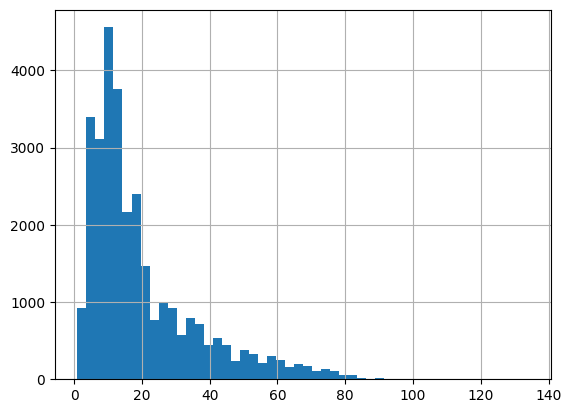

In [ ]:
merged_with_holidays_df['Vehicles'].hist(bins=50)
merged_with_holidays_df['Vehicles'].skew()

In [ ]:
df = merged_with_holidays_df.copy()

<Axes: title={'center': 'Total Vehicles over time'}, xlabel='DateTime'>

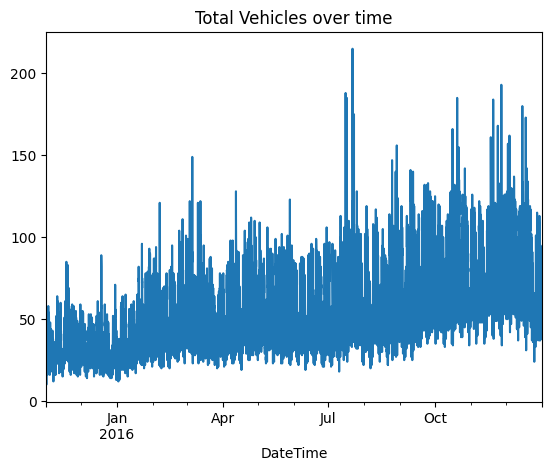

In [ ]:
import matplotlib.pyplot as plt
df.groupby('DateTime')['Vehicles'].sum().plot(title='Total Vehicles over time')

<Axes: title={'center': '1'}, xlabel='DateTime'>

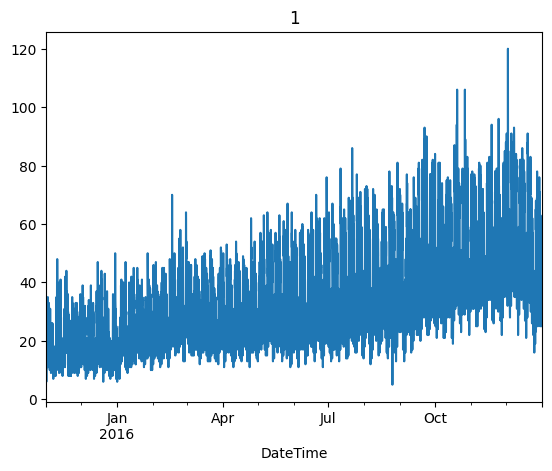

In [ ]:
sample_j = df['Junction'].unique()[0]
df[df['Junction']==sample_j].set_index('DateTime')['Vehicles'].plot(title=sample_j)

/tmp/ipython-input-162694694.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s = df[df['Junction']==sample_j].set_index('DateTime')['Vehicles'].asfreq('H').fillna(0)


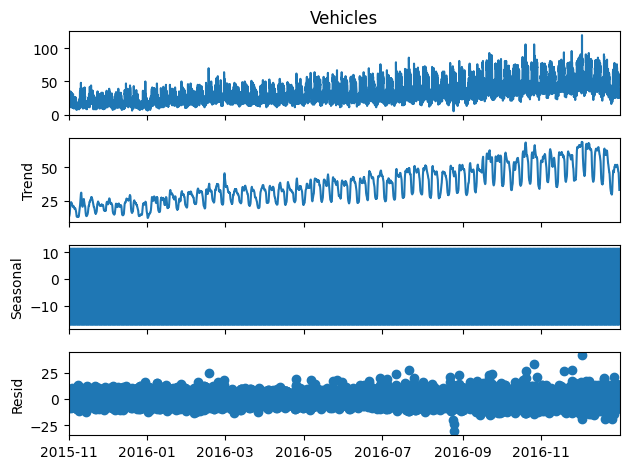

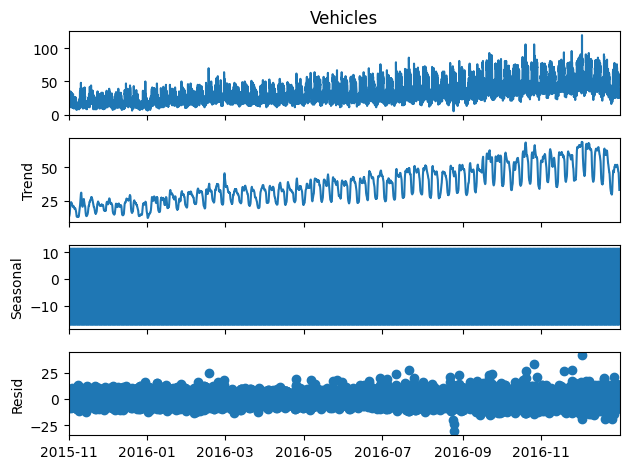

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
s = df[df['Junction']==sample_j].set_index('DateTime')['Vehicles'].asfreq('H').fillna(0)
res = seasonal_decompose(s, period=24)  # daily seasonality
res.plot()


<Axes: xlabel='dow', ylabel='hour'>

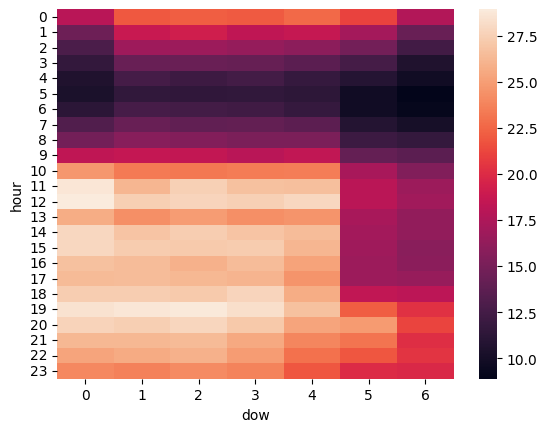

In [ ]:
tmp = df.copy()
tmp['hour'] = tmp['DateTime'].dt.hour
tmp['dow'] = tmp['DateTime'].dt.dayofweek
pivot = tmp.groupby(['hour','dow'])['Vehicles'].mean().unstack()
import seaborn as sns
sns.heatmap(pivot)


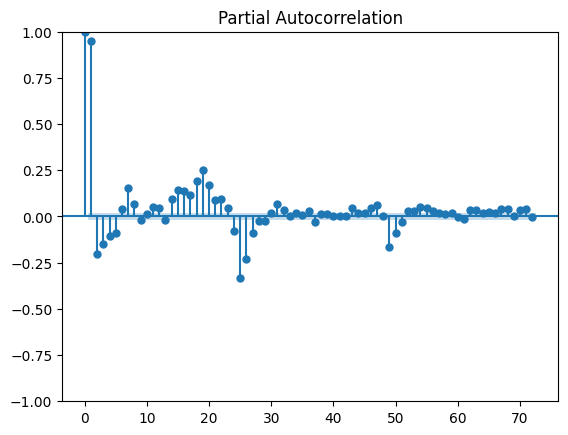

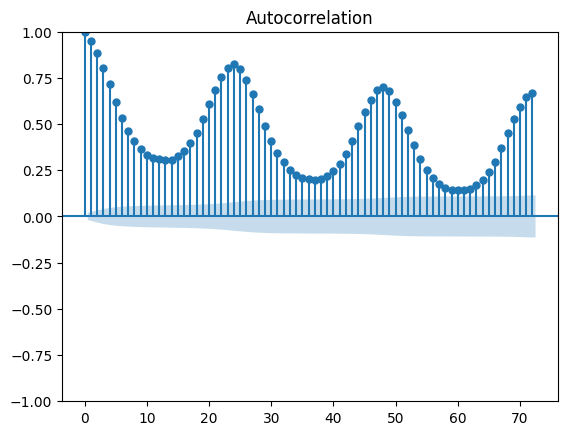

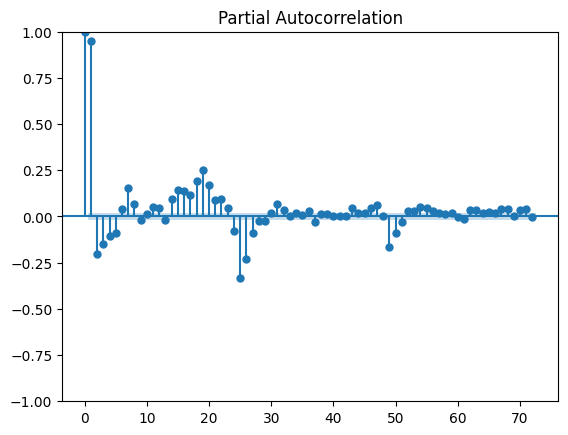

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(s.dropna(), lags=72)
plot_pacf(s.dropna(), lags=72)


In [ ]:
cols = ['Vehicles','Temperature (C)','Apparent Temperature (C)','Humidity','Wind Speed (km/h)','Visibility (km)','Pressure (millibars)']
df[cols].corr()

,Vehicles,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Visibility (km),Pressure (millibars)
Vehicles,1.000000,0.124243,0.118273,-0.119743,0.020846,0.093925,-0.004692
Temperature (C),0.124243,1.000000,0.993763,-0.679160,0.032358,0.524821,-0.060529
Apparent Temperature (C),0.118273,0.993763,1.000000,-0.655126,-0.021690,0.510030,-0.056080
Humidity,-0.119743,-0.679160,-0.655126,1.000000,-0.229789,-0.544643,0.022995
Wind Speed (km/h),0.020846,0.032358,-0.021690,-0.229789,1.000000,0.109304,-0.059419
Visibility (km),0.093925,0.524821,0.510030,-0.544643,0.109304,1.000000,-0.033900
Pressure (millibars),-0.004692,-0.060529,-0.056080,0.022995,-0.059419,-0.033900,1.000000


<Axes: >

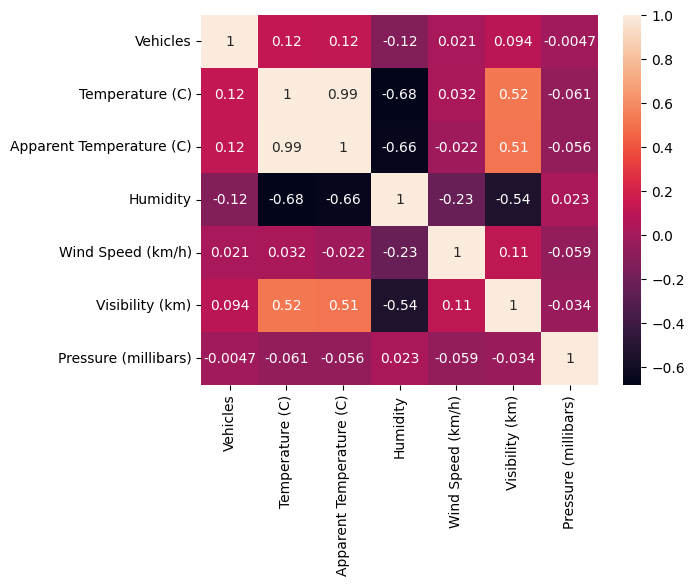

In [ ]:
sns.heatmap(df[cols].corr(), annot=True)

In [ ]:
# Extract time-based features
df['hour'] = df['DateTime'].dt.hour
df['dayofweek'] = df['DateTime'].dt.dayofweek
df['month'] = df['DateTime'].dt.month
df['year'] = df['DateTime'].dt.year

# Weekend indicator
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

# Display the first few rows with the new features
display(df.head())

,DateTime,Junction,Vehicles,ID,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),...,Visibility (km),Pressure (millibars),Daily Summary,year,month,day,is_holiday,hour,dayofweek,is_weekend
0,2015-11-01 00:00:00,1,15,20151101001,Foggy,rain,0.677778,0.677778,0.93,2.8175,...,1.6261,1041.37,Foggy until morning.,2015,11,1,False,0,6,1
1,2015-11-01 01:00:00,1,13,20151101011,Foggy,rain,0.483333,0.483333,0.99,0.0000,...,0.1610,1041.51,Foggy until morning.,2015,11,1,False,1,6,1
2,2015-11-01 02:00:00,1,10,20151101021,Foggy,snow,-0.116667,-0.116667,1.00,3.2200,...,0.1610,1041.33,Foggy until morning.,2015,11,1,False,2,6,1
3,2015-11-01 03:00:00,1,7,20151101031,Foggy,rain,0.155556,0.155556,0.91,3.0751,...,1.6422,1041.40,Foggy until morning.,2015,11,1,False,3,6,1
4,2015-11-01 04:00:00,1,9,20151101041,Clear,snow,-1.183333,-1.183333,1.00,1.6100,...,4.3309,1041.52,Foggy until morning.,2015,11,1,False,4,6,1


### 1.2 Feature Engineering & Selection
- Time-based features (hour, dayofweek, month, year)
- Lag and rolling features (leakage-safe)
- Weekend indicator and holidays
- Text encodings for weather
- Interaction features
- Feature importance (later section)

In [ ]:
# Sort by Junction and DateTime to ensure correct lag calculation within each junction
df = df.sort_values(by=['Junction','DateTime'])

# Create lag features for 'Vehicles' per-junction
df['Vehicles_lag1'] = df.groupby('Junction')['Vehicles'].shift(1)
df['Vehicles_lag2'] = df.groupby('Junction')['Vehicles'].shift(2)
df['Vehicles_lag3'] = df.groupby('Junction')['Vehicles'].shift(3)
df['Vehicles_lag24'] = df.groupby('Junction')['Vehicles'].shift(24)  # Daily seasonality

# Display the first few rows with the new lag features
display(df.head())

,DateTime,Junction,Vehicles,ID,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),...,month,day,is_holiday,hour,dayofweek,is_weekend,Vehicles_lag1,Vehicles_lag2,Vehicles_lag3,Vehicles_lag24
0,2015-11-01 00:00:00,1,15,20151101001,Foggy,rain,0.677778,0.677778,0.93,2.8175,...,11,1,False,0,6,1,NaN,NaN,NaN,NaN
1,2015-11-01 01:00:00,1,13,20151101011,Foggy,rain,0.483333,0.483333,0.99,0.0000,...,11,1,False,1,6,1,15.0,NaN,NaN,NaN
2,2015-11-01 02:00:00,1,10,20151101021,Foggy,snow,-0.116667,-0.116667,1.00,3.2200,...,11,1,False,2,6,1,13.0,15.0,NaN,NaN
3,2015-11-01 03:00:00,1,7,20151101031,Foggy,rain,0.155556,0.155556,0.91,3.0751,...,11,1,False,3,6,1,10.0,13.0,15.0,NaN
4,2015-11-01 04:00:00,1,9,20151101041,Clear,snow,-1.183333,-1.183333,1.00,1.6100,...,11,1,False,4,6,1,7.0,10.0,13.0,NaN


In [ ]:
# Create rolling window features for 'Vehicles' grouped by 'Junction'
# Using closed='left' to avoid data leakage
# Ensure sorted by Junction & DateTime before rolling
df = df.sort_values(by=['Junction','DateTime'])
df['Vehicles_rolling_mean_24'] = (
    df.groupby('Junction')['Vehicles']
      .rolling(window=24, closed='left')
      .mean()
      .reset_index(level=0, drop=True)
)
df['Vehicles_rolling_std_24'] = (
    df.groupby('Junction')['Vehicles']
      .rolling(window=24, closed='left')
      .std()
      .reset_index(level=0, drop=True)
)

# Display the first few rows with the new rolling features
display(df.head())

,DateTime,Junction,Vehicles,ID,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),...,is_holiday,hour,dayofweek,is_weekend,Vehicles_lag1,Vehicles_lag2,Vehicles_lag3,Vehicles_lag24,Vehicles_rolling_mean_24,Vehicles_rolling_std_24
0,2015-11-01 00:00:00,1,15,20151101001,Foggy,rain,0.677778,0.677778,0.93,2.8175,...,False,0,6,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-11-01 01:00:00,1,13,20151101011,Foggy,rain,0.483333,0.483333,0.99,0.0000,...,False,1,6,1,15.0,NaN,NaN,NaN,NaN,NaN
2,2015-11-01 02:00:00,1,10,20151101021,Foggy,snow,-0.116667,-0.116667,1.00,3.2200,...,False,2,6,1,13.0,15.0,NaN,NaN,NaN,NaN
3,2015-11-01 03:00:00,1,7,20151101031,Foggy,rain,0.155556,0.155556,0.91,3.0751,...,False,3,6,1,10.0,13.0,15.0,NaN,NaN,NaN
4,2015-11-01 04:00:00,1,9,20151101041,Clear,snow,-1.183333,-1.183333,1.00,1.6100,...,False,4,6,1,7.0,10.0,13.0,NaN,NaN,NaN


In [ ]:
# Show the count of NaN values per column
print("Number of NaN values per column:")
print(df.isnull().sum())

Number of NaN values per column:
DateTime                     0
Junction                     0
Vehicles                     0
ID                           0
Summary                      0
Precip Type                  0
Temperature (C)              0
Apparent Temperature (C)     0
Humidity                     0
Wind Speed (km/h)            0
Wind Bearing (degrees)       0
Visibility (km)              0
Pressure (millibars)         0
Daily Summary                0
year                         0
month                        0
day                          0
is_holiday                   0
hour                         0
dayofweek                    0
is_weekend                   0
Vehicles_lag1                3
Vehicles_lag2                6
Vehicles_lag3                9
Vehicles_lag24              72
Vehicles_rolling_mean_24    72
Vehicles_rolling_std_24     72
dtype: int64


In [ ]:
# Remove rows with any NaN values
df = df.dropna()

# Display the first few rows and check for NaNs again
display(df.head())
print("\nNumber of NaN values per column after removing rows:")
print(df.isnull().sum())

,DateTime,Junction,Vehicles,ID,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),...,is_holiday,hour,dayofweek,is_weekend,Vehicles_lag1,Vehicles_lag2,Vehicles_lag3,Vehicles_lag24,Vehicles_rolling_mean_24,Vehicles_rolling_std_24
24,2015-11-02 00:00:00,1,14,20151102001,Foggy,snow,-1.483333,-1.483333,0.97,3.0751,...,False,0,0,0,15.0,20.0,19.0,15.0,13.625000,4.030455
25,2015-11-02 01:00:00,1,12,20151102011,Foggy,snow,-2.266667,-2.266667,0.93,3.1717,...,False,1,0,0,14.0,15.0,20.0,13.0,13.583333,4.020779
26,2015-11-02 02:00:00,1,14,20151102021,Foggy,snow,-2.777778,-2.777778,0.92,0.0000,...,False,2,0,0,12.0,14.0,15.0,10.0,13.541667,4.032252
27,2015-11-02 03:00:00,1,12,20151102031,Foggy,snow,-3.155556,-3.155556,0.93,3.2200,...,False,3,0,0,14.0,12.0,14.0,7.0,13.708333,3.961545
28,2015-11-02 04:00:00,1,12,20151102041,Foggy,snow,-2.844444,-2.844444,0.93,0.0000,...,False,4,0,0,12.0,14.0,12.0,9.0,13.916667,3.717370



Number of NaN values per column after removing rows:
DateTime                    0
Junction                    0
Vehicles                    0
ID                          0
Summary                     0
Precip Type                 0
Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Pressure (millibars)        0
Daily Summary               0
year                        0
month                       0
day                         0
is_holiday                  0
hour                        0
dayofweek                   0
is_weekend                  0
Vehicles_lag1               0
Vehicles_lag2               0
Vehicles_lag3               0
Vehicles_lag24              0
Vehicles_rolling_mean_24    0
Vehicles_rolling_std_24     0
dtype: int64


In [ ]:
# Treat categorical columns appropriately
if 'Junction' in df.columns:
    df['Junction'] = df['Junction'].astype('category')

# Optionally rename columns to remove spaces to avoid LightGBM warnings
df = df.rename(columns=lambda c: c.replace(' ', '_'))

# Define features and target
features = [
    'Junction', 'Temperature_(C)', 'Apparent_Temperature_(C)', 'Humidity',
    'Wind_Speed_(km/h)', 'Wind_Bearing_(degrees)', 'Visibility_(km)',
    'Pressure_(millibars)', 'is_holiday', 'is_weekend', 'hour', 'dayofweek', 'month', 'year',
    'Vehicles_lag1', 'Vehicles_lag2', 'Vehicles_lag3', 'Vehicles_lag24',
    'Vehicles_rolling_mean_24', 'Vehicles_rolling_std_24',
    # Encoded weather frequencies
    'Summary_freq', 'Daily_Summary_freq', 'Precip_Type_freq',
    # Interaction features
    'hour_dayofweek_interaction', 'temp_humidity_interaction', 'weekend_hour_interaction'
]

# Keep only features that actually exist (after renaming)
features = [f for f in features if f in df.columns]

# Target column also renamed if it had spaces
target = 'Vehicles'

print("Selected Features:")
print(features)
print("\nTarget Variable:")
print(target)

Selected Features:
['Junction', 'Temperature_(C)', 'Apparent_Temperature_(C)', 'Humidity', 'Wind_Speed_(km/h)', 'Wind_Bearing_(degrees)', 'Visibility_(km)', 'Pressure_(millibars)', 'is_holiday', 'is_weekend', 'hour', 'dayofweek', 'month', 'year', 'Vehicles_lag1', 'Vehicles_lag2', 'Vehicles_lag3', 'Vehicles_lag24', 'Vehicles_rolling_mean_24', 'Vehicles_rolling_std_24']

Target Variable:
Vehicles


In [ ]:

# Ensure chronological order
df = df.sort_values('DateTime').reset_index(drop=True)

# Choose split strategy based on data span
span_days = (df['DateTime'].max() - df['DateTime'].min()).days
if span_days >= 180:
    split_test = df['DateTime'].max() - pd.Timedelta(days=90)   # last ~3 months for test
    split_val = split_test - pd.Timedelta(days=60)               # ~2 months for validation before test
else:
    # Fallback to quantile-based if dataset is short
    split_val = df['DateTime'].quantile(0.7)
    split_test = df['DateTime'].quantile(0.85)

# Masks
train_mask = df['DateTime'] <= split_val
val_mask = (df['DateTime'] > split_val) & (df['DateTime'] <= split_test)
test_mask = df['DateTime'] > split_test

# Build X/y matrices
X_train = df.loc[train_mask, features].copy()
y_train = df.loc[train_mask, target].copy()
X_val = df.loc[val_mask, features].copy()
y_val = df.loc[val_mask, target].copy()
X_test = df.loc[test_mask, features].copy()
y_test = df.loc[test_mask, target].copy()

# Keep index of DateTime for plotting later
test_dt_index = df.loc[test_mask, 'DateTime'].copy()

print('Split summary:')
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"split_val={split_val}, split_test={split_test}")

Split summary:
Train: (19869, 20), Val: (4320, 20), Test: (6480, 20)
split_val=2016-08-03 22:00:00, split_test=2016-10-02 22:00:00


In [ ]:
from lightgbm import LGBMRegressor

# Define the model with sensible defaults for time series
a_model = LGBMRegressor(
    random_state=42,
    n_estimators=5000,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    max_depth=-1
)

print(a_model)

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.03, n_estimators=5000,
              random_state=42, subsample=0.8)


## 2. Data Modeling & Model Evaluation

### 2.1 Model Development and Training
- Baseline ARIMA (univariate)
- Tree-based model (LightGBM)
- Optional: LSTM (sequence model) outline

In [ ]:
# Make predictions on the test set
# Ensure model is trained (safety for execution order)
if not hasattr(a_model, 'booster_'):
    print("Model not fitted yet. Training now before prediction...")
    import lightgbm as lgb
    # Detect categorical features from X_train directly to avoid name mismatches
    categorical_features = [i for i, c in enumerate(X_train.columns) if str(X_train[c].dtype) == 'category']
    a_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='l2',
        callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)],
        categorical_feature=categorical_features
    )

predictions = a_model.predict(X_test)

# Display the first few predictions
print("First 10 predictions:")
print(predictions[:10])

Model not fitted yet. Training now before prediction...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2445
[LightGBM] [Info] Number of data points in the train set: 19869, number of used features: 19
[LightGBM] [Info] Start training from score 16.943933
First 10 predictions:
[12.09777453 48.9850352  26.80791726 13.92142788 41.30397879 30.62295948
 12.75101695 35.1907044  26.30593149 10.88296823]


In [ ]:
# Train the model with early stopping on validation set
# Skip training if already fitted (useful if cells are run out of order)
if hasattr(a_model, 'booster_'):
    print("Model already trained; skipping fit.")
else:
    import lightgbm as lgb
    # Detect categorical features from X_train directly to avoid name mismatches
    categorical_features = [i for i, c in enumerate(X_train.columns) if str(X_train[c].dtype) == 'category']
    a_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='l2',
        callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)],
        categorical_feature=categorical_features
    )
    print("Model training complete.")

Model already trained; skipping fit.


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Evaluate the predictions
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f"LightGBM -> MAE: {mae:.3f}, RMSE: {rmse:.3f}")

LightGBM -> MAE: 3.196, RMSE: 5.104


### 2.2 Model Evaluation & Cross-Validation
- Metrics: MAE, RMSE, R-squared
- Visual diagnostics: Residual plots, Pred vs Actual, Error distribution
- Time-based cross-validation / backtesting

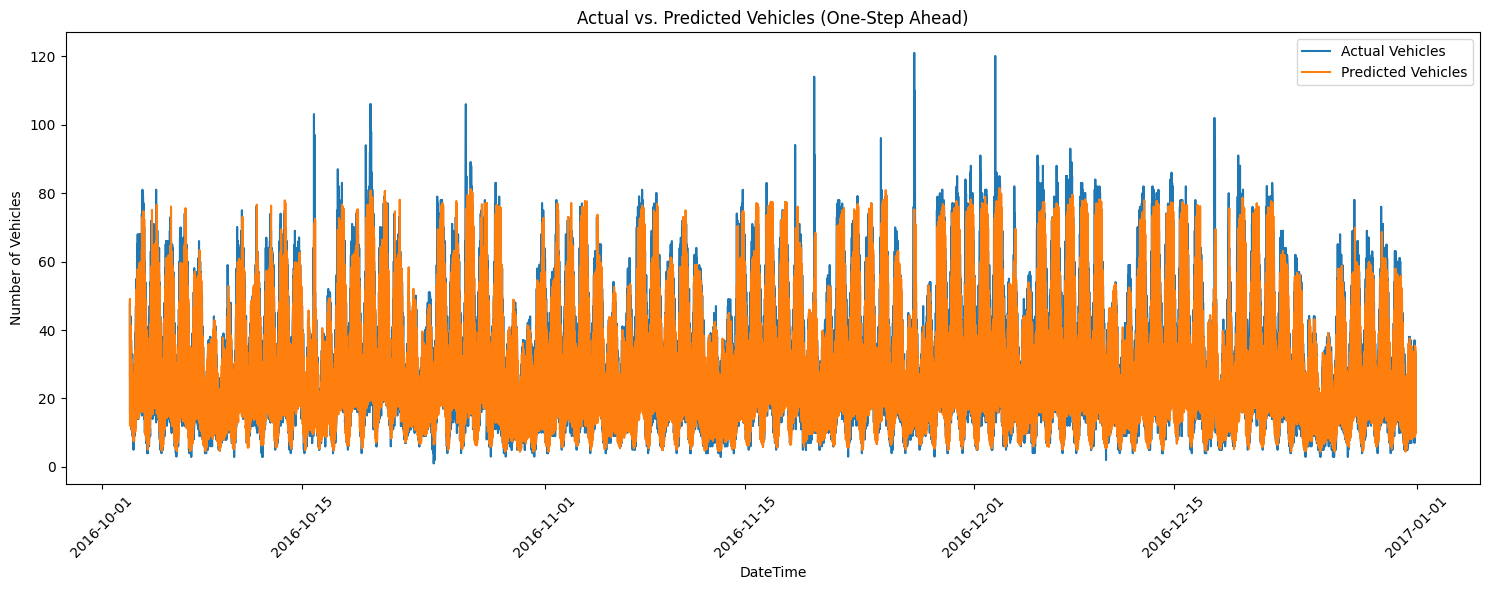

In [ ]:
import matplotlib.pyplot as plt

# Create a dataframe for visualization with DateTime index
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
results_df.index = df.loc[test_mask, 'DateTime']
results_df = results_df.sort_index()

plt.figure(figsize=(15, 6))
plt.plot(results_df.index, results_df['Actual'], label='Actual Vehicles')
plt.plot(results_df.index, results_df['Predicted'], label='Predicted Vehicles')
plt.title('Actual vs. Predicted Vehicles (One-Step Ahead)')
plt.xlabel('DateTime')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Task
Refine the feature engineering in the notebook by creating interaction features, encoding weather features, and refining holiday features. Then, re-prepare the data, train the LightGBM model, and evaluate its performance.

In [ ]:
# Create a new interaction feature by multiplying the 'hour' and 'dayofweek' columns
if 'hour' in df.columns and 'dayofweek' in df.columns:
    df['hour_dayofweek_interaction'] = df['hour'] * df['dayofweek']

# Create another interaction feature by multiplying the 'Temperature (C)' and 'Humidity' columns
temp_col = 'Temperature (C)' if 'Temperature (C)' in df.columns else 'Temperature_(C)'
if temp_col in df.columns and 'Humidity' in df.columns:
    df['temp_humidity_interaction'] = df[temp_col] * df['Humidity']

# Weekend x hour interaction
if 'is_weekend' in df.columns:
    df['weekend_hour_interaction'] = df['is_weekend'] * df['hour']

# Display the first few rows of the DataFrame to show the newly created interaction features
display(df.head())

,DateTime,Junction,Vehicles,ID,Summary,Precip_Type,Temperature_(C),Apparent_Temperature_(C),Humidity,Wind_Speed_(km/h),...,is_weekend,Vehicles_lag1,Vehicles_lag2,Vehicles_lag3,Vehicles_lag24,Vehicles_rolling_mean_24,Vehicles_rolling_std_24,hour_dayofweek_interaction,temp_humidity_interaction,weekend_hour_interaction
0,2015-11-02 00:00:00,1,14,20151102001,Foggy,snow,-1.483333,-1.483333,0.97,3.0751,...,0,15.0,20.0,19.0,15.0,13.625000,4.030455,0,-1.438833,0
1,2015-11-02 00:00:00,3,5,20151102003,Foggy,snow,-1.483333,-1.483333,0.97,3.0751,...,0,5.0,6.0,8.0,9.0,5.666667,2.729336,0,-1.438833,0
2,2015-11-02 00:00:00,2,8,20151102002,Foggy,snow,-1.483333,-1.483333,0.97,3.0751,...,0,4.0,9.0,5.0,6.0,5.541667,1.841058,0,-1.438833,0
3,2015-11-02 01:00:00,1,12,20151102011,Foggy,snow,-2.266667,-2.266667,0.93,3.1717,...,0,14.0,15.0,20.0,13.0,13.583333,4.020779,0,-2.108000,0
4,2015-11-02 01:00:00,3,3,20151102013,Foggy,snow,-2.266667,-2.266667,0.93,3.1717,...,0,5.0,5.0,6.0,7.0,5.500000,2.637522,0,-2.108000,0


**Reasoning**:
Use one-hot encoding to convert the categorical 'Summary' and 'Daily Summary' columns into numerical features and concatenate them with the existing dataframe.



In [ ]:
# Replace high-cardinality one-hot with frequency encoding to avoid feature explosion
for col in ['Summary', 'Daily Summary']:
    if col in df.columns:
        freqs = df[col].value_counts(normalize=True)
        df[f'{col}_freq'] = df[col].map(freqs).fillna(0)

# Keep original columns for reference but they won't be used as features
# Don't drop DateTime here; needed for splits and additional features

# Encode 'Precip Type' as categorical frequency as well if present
if 'Precip Type' in df.columns:
    freqs = df['Precip Type'].value_counts(normalize=True)
    df['Precip_Type_freq'] = df['Precip Type'].map(freqs).fillna(0)

display(df.head())

,DateTime,Junction,Vehicles,ID,Summary,Precip_Type,Temperature_(C),Apparent_Temperature_(C),Humidity,Wind_Speed_(km/h),...,Vehicles_lag1,Vehicles_lag2,Vehicles_lag3,Vehicles_lag24,Vehicles_rolling_mean_24,Vehicles_rolling_std_24,hour_dayofweek_interaction,temp_humidity_interaction,weekend_hour_interaction,Summary_freq
0,2015-11-02 00:00:00,1,14,20151102001,Foggy,snow,-1.483333,-1.483333,0.97,3.0751,...,15.0,20.0,19.0,15.0,13.625000,4.030455,0,-1.438833,0,0.087156
1,2015-11-02 00:00:00,3,5,20151102003,Foggy,snow,-1.483333,-1.483333,0.97,3.0751,...,5.0,6.0,8.0,9.0,5.666667,2.729336,0,-1.438833,0,0.087156
2,2015-11-02 00:00:00,2,8,20151102002,Foggy,snow,-1.483333,-1.483333,0.97,3.0751,...,4.0,9.0,5.0,6.0,5.541667,1.841058,0,-1.438833,0,0.087156
3,2015-11-02 01:00:00,1,12,20151102011,Foggy,snow,-2.266667,-2.266667,0.93,3.1717,...,14.0,15.0,20.0,13.0,13.583333,4.020779,0,-2.108000,0,0.087156
4,2015-11-02 01:00:00,3,3,20151102013,Foggy,snow,-2.266667,-2.266667,0.93,3.1717,...,5.0,5.0,6.0,7.0,5.500000,2.637522,0,-2.108000,0,0.087156


**Reasoning**:
Create dummy variables for the 'Name' column in Holiday_data, merge them into the main dataframe based on month and day, and fill NaN values with 0.



In [ ]:
# Baselines for comparison using lag features (no reindex issues)
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Naive-1 baseline: use previous hour actuals already in Vehicles_lag1
naive1 = df.loc[test_mask, 'Vehicles_lag1']
# Seasonal-24 baseline: use value from 24 hours ago
seasonal24 = df.loc[test_mask, 'Vehicles_lag24']

# Align to available rows (drop initial NaNs from lags)
mask1 = ~naive1.isna()
mask24 = ~seasonal24.isna()

mae_naive1 = mean_absolute_error(y_test[mask1], naive1[mask1])
rmse_naive1 = np.sqrt(mean_squared_error(y_test[mask1], naive1[mask1]))
mae_seasonal24 = mean_absolute_error(y_test[mask24], seasonal24[mask24])
rmse_seasonal24 = np.sqrt(mean_squared_error(y_test[mask24], seasonal24[mask24]))

print(f"Naive-1 -> MAE: {mae_naive1:.3f}, RMSE: {rmse_naive1:.3f}")
print(f"Seasonal-24 -> MAE: {mae_seasonal24:.3f}, RMSE: {rmse_seasonal24:.3f}")

Naive-1 -> MAE: 3.535, RMSE: 5.448
Seasonal-24 -> MAE: 5.825, RMSE: 10.076


In [ ]:
# Compare model to baselines and print metrics inline
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

print("\nComparison (lower is better):")
mae_model = mean_absolute_error(y_test, predictions)
rmse_model = np.sqrt(mean_squared_error(y_test, predictions))
print(f"LightGBM -> MAE: {mae_model:.3f}, RMSE: {rmse_model:.3f}")

# If baseline metrics are available from earlier cell variables, print them too
try:
    print(f"Naive-1 -> MAE: {mae_naive1:.3f}, RMSE: {rmse_naive1:.3f}")
    print(f"Seasonal-24 -> MAE: {mae_seasonal24:.3f}, RMSE: {rmse_seasonal24:.3f}")
except NameError:
    pass


Comparison (lower is better):
LightGBM -> MAE: 3.196, RMSE: 5.104
Naive-1 -> MAE: 3.535, RMSE: 5.448
Seasonal-24 -> MAE: 5.825, RMSE: 10.076


### 2.3 Model Refinement
- Diagnose issues (bias/variance)
- Refine features
- Hyperparameter tuning (random search over LGBM)

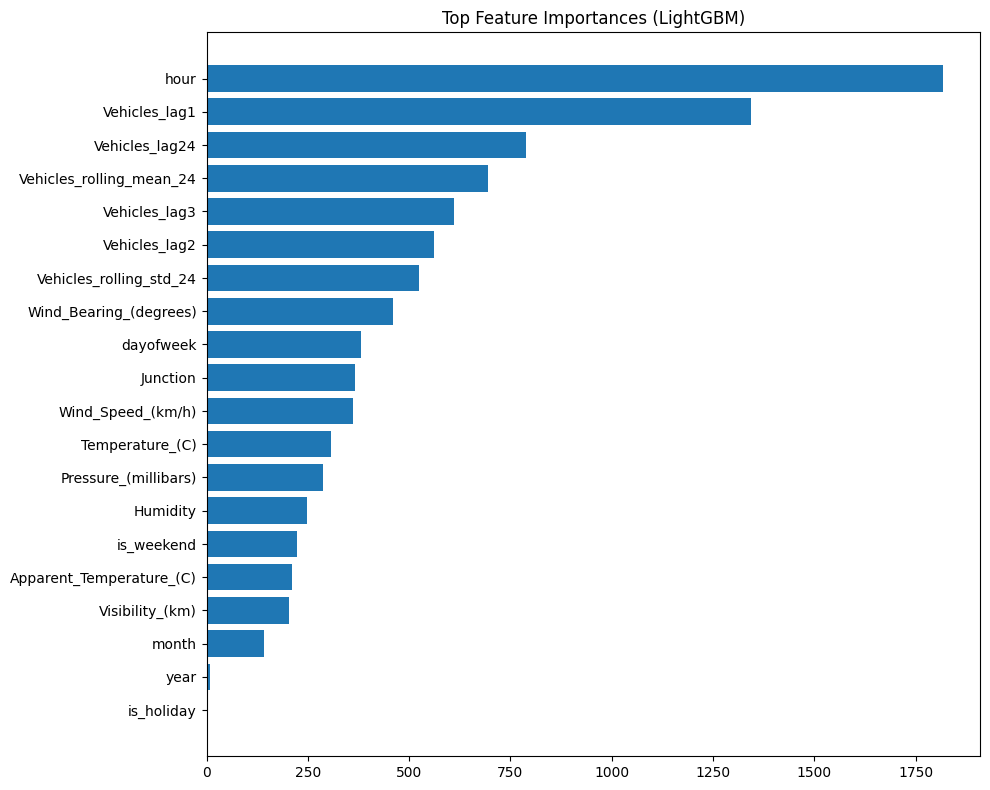

In [ ]:
# Feature importance for LightGBM
import numpy as np
import matplotlib.pyplot as plt

try:
    importances = a_model.feature_importances_
    idx_sorted = np.argsort(importances)[::-1][:25]
    plt.figure(figsize=(10, 8))
    plt.barh(np.array(X_train.columns)[idx_sorted][::-1], importances[idx_sorted][::-1])
    plt.title('Top Feature Importances (LightGBM)')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Feature importance plot skipped: {e}")

In [ ]:
# Random search hyperparameter tuning for LightGBM with time-based folds (lightweight)
import numpy as np
from itertools import product
from sklearn.metrics import mean_absolute_error

# Reuse folds from earlier CV cell if available; otherwise build simple quantile folds
data = df.copy()
X_all = data[features].copy()
y_all = data[target].copy()
dates_all = data['DateTime']
if 'Junction' in X_all.columns and str(X_all['Junction'].dtype) != 'category':
    X_all['Junction'] = X_all['Junction'].astype('category')

folds = []
if 'split_val' in globals() and 'split_test' in globals():
    folds.append((dates_all <= split_val, (dates_all > split_val) & (dates_all <= split_test)))
    cutoff2 = dates_all.quantile(0.9)
    folds.append((dates_all <= split_test, dates_all > cutoff2))
else:
    q1, q2, q3 = dates_all.quantile([0.6, 0.8, 0.9])
    folds.append((dates_all <= q1, (dates_all > q1) & (dates_all <= q2)))
    folds.append((dates_all <= q2, (dates_all > q2) & (dates_all <= q3)))

import lightgbm as lgb
param_grid = {
    'learning_rate': [0.05, 0.03],
    'num_leaves': [31, 63, 127],
    'min_child_samples': [20, 50],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

best_score = float('inf')
best_params = None

for lr, nl, mcs, ss, cs in product(param_grid['learning_rate'], param_grid['num_leaves'], param_grid['min_child_samples'], param_grid['subsample'], param_grid['colsample_bytree']):
    mae_fold_scores = []
    for (train_idx, val_idx) in folds:
        X_tr, y_tr = X_all[train_idx], y_all[train_idx]
        X_va, y_va = X_all[val_idx], y_all[val_idx]

        model = LGBMRegressor(
            random_state=42,
            n_estimators=3000,
            learning_rate=lr,
            num_leaves=nl,
            min_child_samples=mcs,
            subsample=ss,
            colsample_bytree=cs,
        )
        cat_idx = [i for i, c in enumerate(X_tr.columns) if str(X_tr[c].dtype) == 'category']
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            eval_metric='l2',
            callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)],
            categorical_feature=cat_idx
        )
        preds = model.predict(X_va)
        mae_fold_scores.append(mean_absolute_error(y_va, preds))

    avg_mae = np.mean(mae_fold_scores)
    if avg_mae < best_score:
        best_score = avg_mae
        best_params = {'learning_rate': lr, 'num_leaves': nl, 'min_child_samples': mcs, 'subsample': ss, 'colsample_bytree': cs}
        print(f"New best -> MAE: {best_score:.3f} with {best_params}")

print(f"\nBest params from random search: {best_params}, MAE: {best_score:.3f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2445
[LightGBM] [Info] Number of data points in the train set: 19869, number of used features: 19
[LightGBM] [Info] Start training from score 16.943933
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2496
[LightGBM] [Info] Number of data points in the train set: 24189, number of used features: 19
[LightGBM] [Info] Start training from score 18.140560
New best -> MAE: 2.674 with {'learning_rate': 0.05, 'num_leaves': 31, 'min_child_samples': 20, 'subsample': 0.8, 'colsample_bytree': 0.8}
[LightGBM] [Info] Auto-choosing row-wise multi-t